# Performance evolution of the simdjson library

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
from statsmodels.formula.api import ols
from numpy import log, mean, std

warnings.simplefilter(action='ignore')

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def read_csv(archive_name, file_name):
    archive = zipfile.ZipFile(archive_name)
    res = pandas.read_csv(io.BytesIO(archive.read(file_name)))
    res['filename'] = archive_name
    return res

def read_result(name):
    res = read_csv(name, 'results.csv')
    res['start'] = pandas.to_datetime(res['start'])
    res['stop'] = pandas.to_datetime(res['stop'])
    res['timestamp'] = res['start'] - res['start'].min()
    info = get_yaml(name, 'info.yaml')
    res['cluster'] = info['cluster']
    installfile = info['installfile']
    installfile = get_yaml(name, installfile)
    res['version'] = installfile['version']
    res['global_id'] = -1
    nb_calls = installfile['nb_runs']*installfile['nb_calls']
    for host in res['hostname'].unique():
        res.loc[res['hostname'] == host, 'global_id'] = range(nb_calls)
    res['run_id'] = res['global_id'] // installfile['nb_calls']
    res['call_id'] = res['global_id'] % installfile['nb_calls']
    return res

directory = '1/'
all_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.zip')]

df = pandas.concat([read_result(f) for f in all_files])
df.head()

,hostname,duration,gigabytes_per_second,start,stop,filename,timestamp,cluster,version,global_id,run_id,call_id
0,dahu-2.grenoble.grid5000.fr,0.001334,0.473407,2020-04-27 19:01:19.983032,2020-04-27 19:01:20.015143,1/grenoble_2020-04-27_1928773.zip,0 days,dahu,v0.3.1,0,0,0
1,dahu-2.grenoble.grid5000.fr,0.000671,0.941614,2020-04-27 19:01:19.983032,2020-04-27 19:01:20.015143,1/grenoble_2020-04-27_1928773.zip,0 days,dahu,v0.3.1,1,0,1
2,dahu-2.grenoble.grid5000.fr,0.000273,2.315982,2020-04-27 19:01:19.983032,2020-04-27 19:01:20.015143,1/grenoble_2020-04-27_1928773.zip,0 days,dahu,v0.3.1,2,0,2
3,dahu-2.grenoble.grid5000.fr,0.000265,2.379394,2020-04-27 19:01:19.983032,2020-04-27 19:01:20.015143,1/grenoble_2020-04-27_1928773.zip,0 days,dahu,v0.3.1,3,0,3
4,dahu-2.grenoble.grid5000.fr,0.000263,2.402431,2020-04-27 19:01:19.983032,2020-04-27 19:01:20.015143,1/grenoble_2020-04-27_1928773.zip,0 days,dahu,v0.3.1,4,0,4


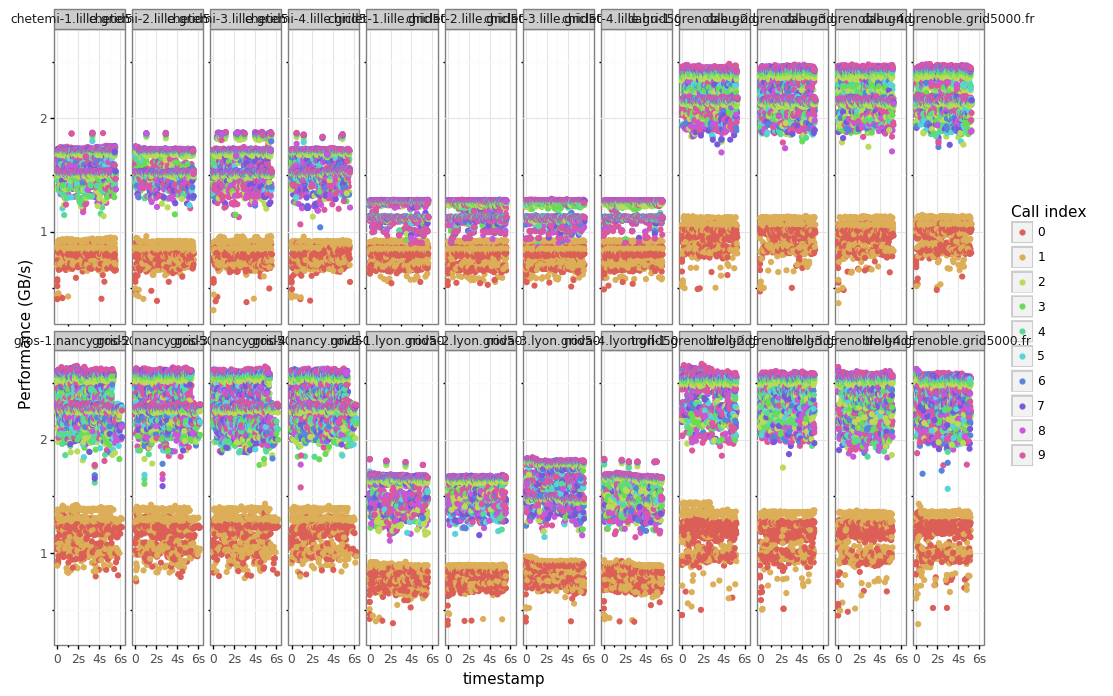

<ggplot: (-9223363290738233561)>

In [2]:
ggplot(df) +\
    aes(x='timestamp', y='gigabytes_per_second', color='factor(call_id)') +\
    geom_point() +\
    facet_wrap('hostname', nrow=2) +\
    ylab('Performance (GB/s)') +\
    labs(color='Call index') +\
    theme_bw()

Alright, let's remove the first two calls for each run.

In [3]:
df = df[df['call_id'] > 1]

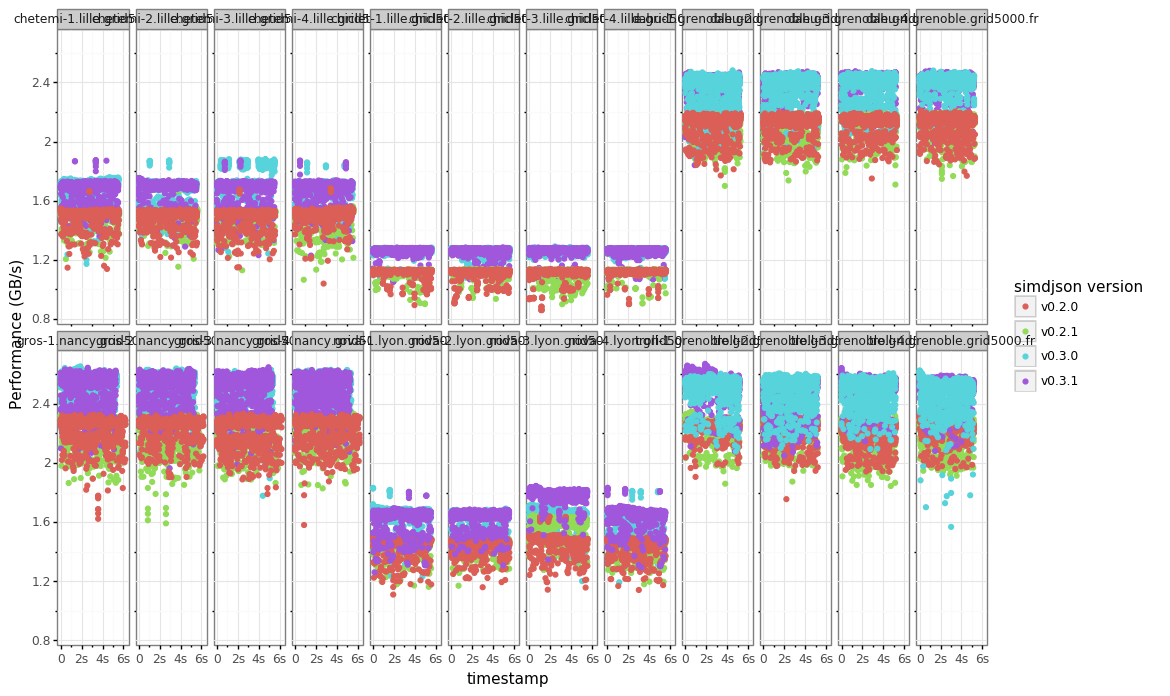

<ggplot: (8746107550149)>

In [4]:
ggplot(df) +\
    aes(x='timestamp', y='gigabytes_per_second', color='version') +\
    geom_point() +\
    facet_wrap('hostname', nrow=2) +\
    ylab('Performance (GB/s)') +\
    labs(color='simdjson version') +\
    theme_bw()

(0.8589259532287504, 2.6707166993009364)


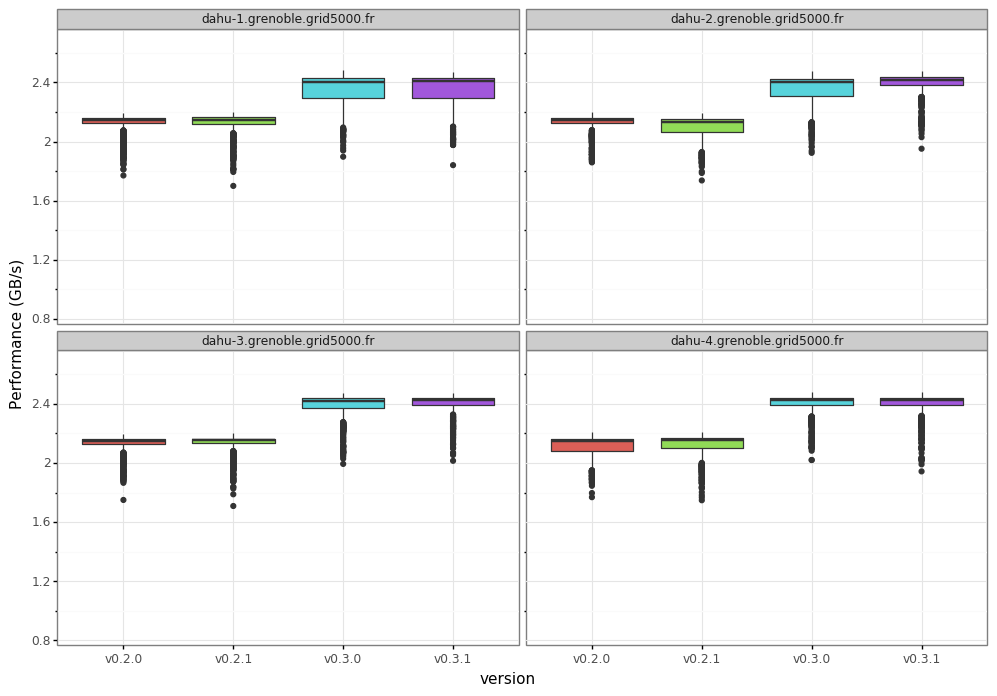

<ggplot: (8746105741362)>


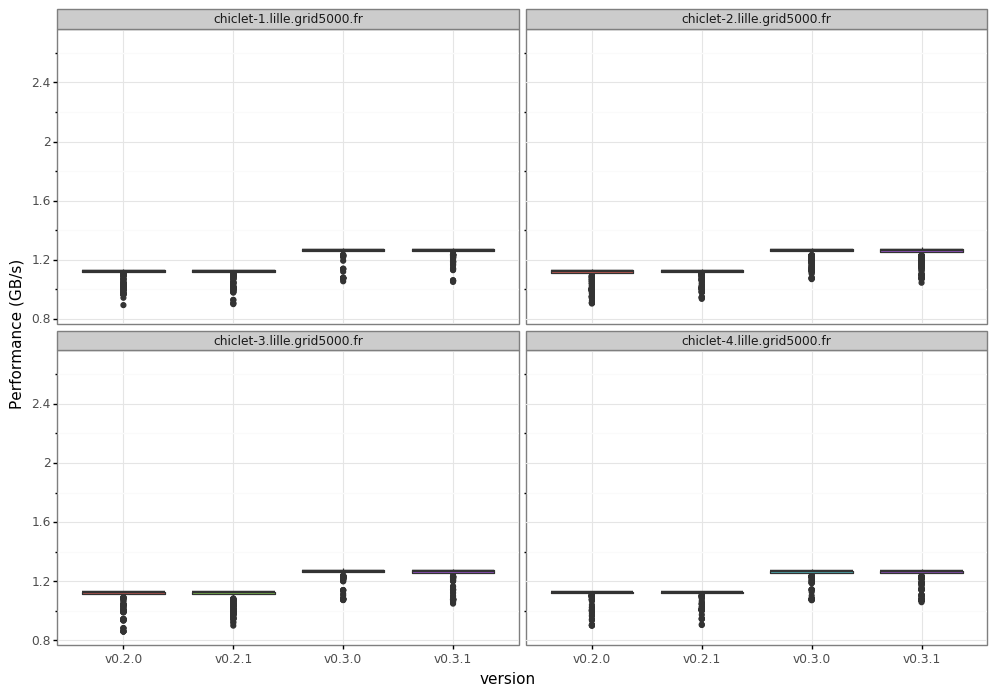

<ggplot: (-9223363290747128646)>


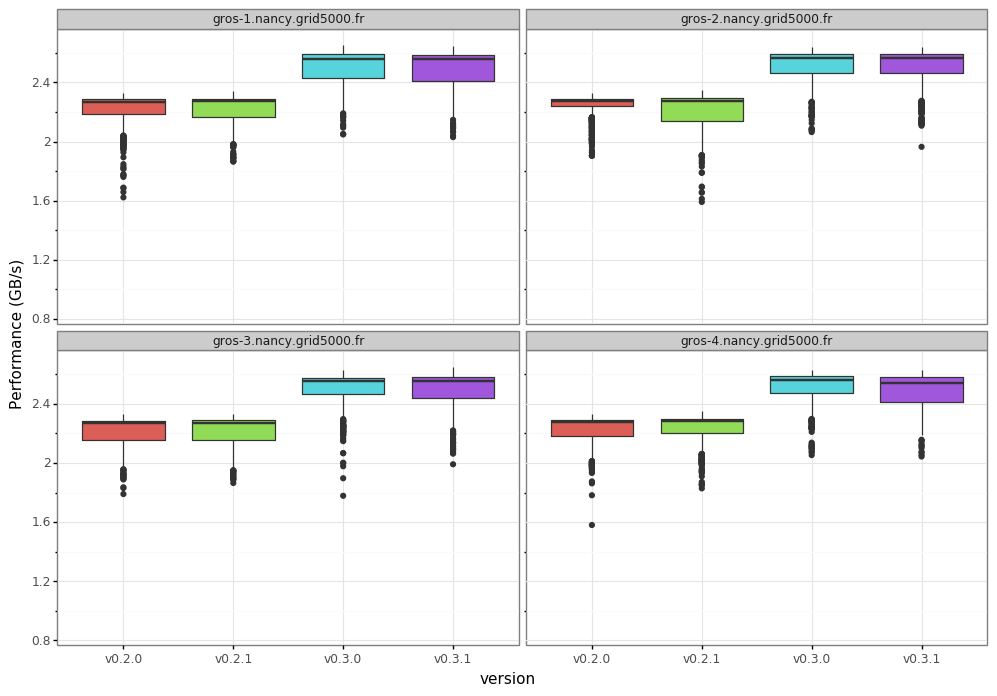

<ggplot: (-9223363290745714481)>


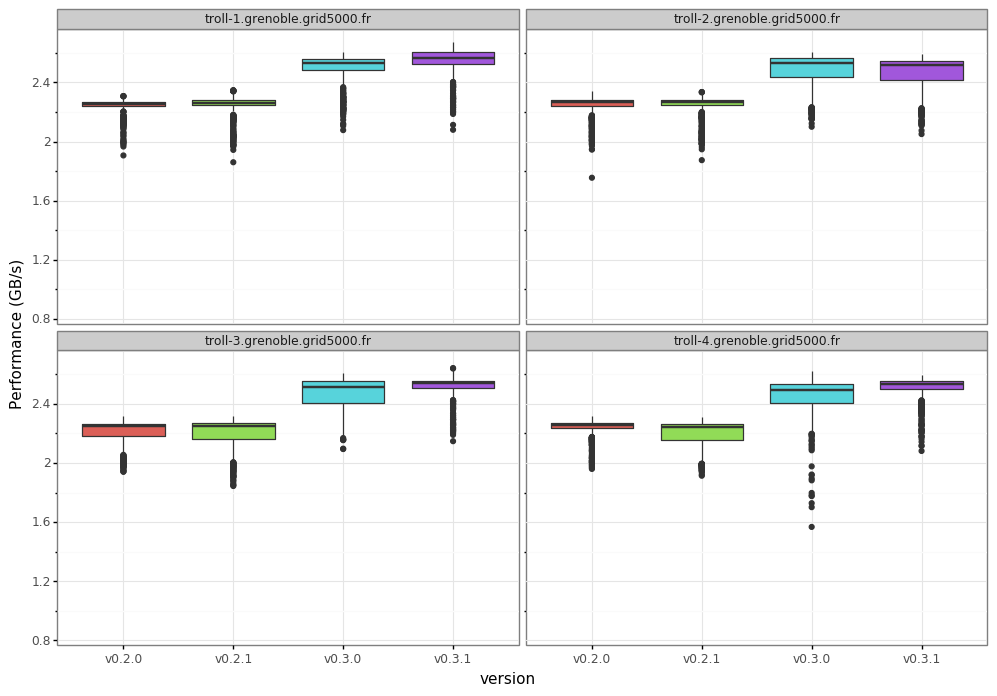

<ggplot: (-9223363290746120988)>


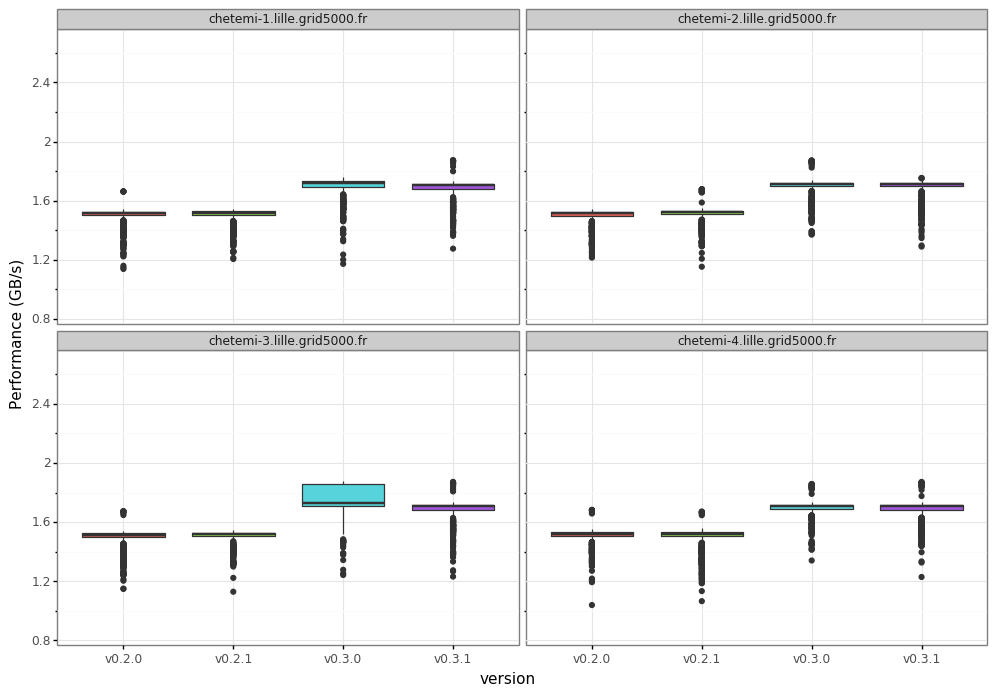

<ggplot: (-9223363290745763370)>


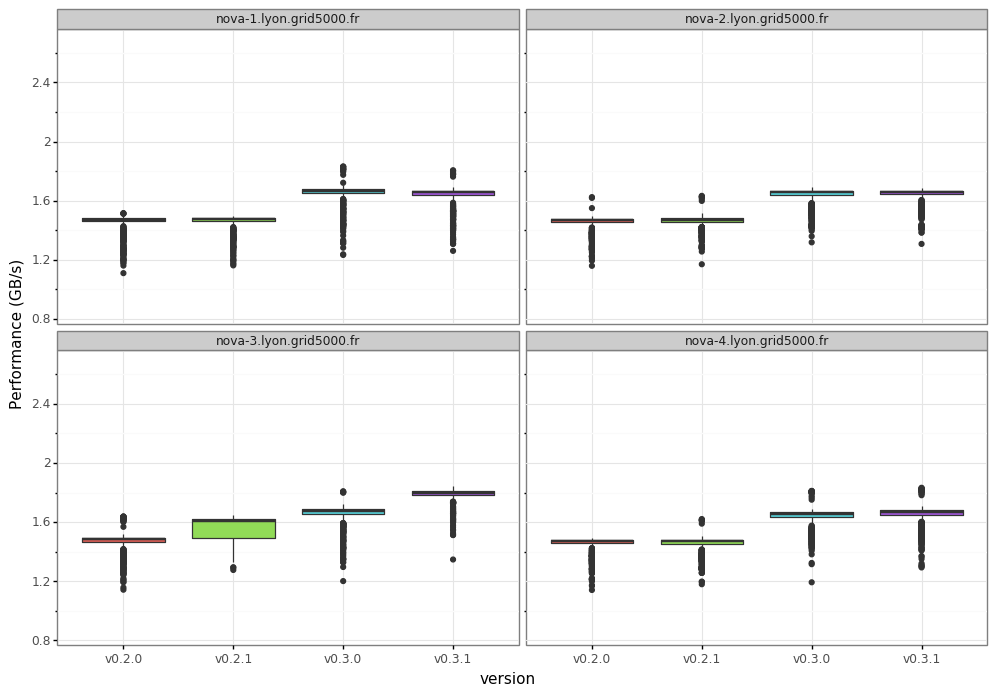

<ggplot: (8746105743119)>


In [5]:
ycol = 'gigabytes_per_second'
minmax = (df[ycol].min(), df[ycol].max())
print(minmax)

for cluster in df['cluster'].unique():
    plot = ggplot(df[df['cluster'] == cluster]) +\
        aes(x='version', y=ycol, fill='version') +\
        geom_boxplot() +\
        facet_wrap('hostname', nrow=2) +\
        theme_bw() +\
        expand_limits(y=minmax) +\
        ylab('Performance (GB/s)') +\
        labs(fill='simdjson version') +\
        theme(legend_position='none')
    print(plot)